In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

In [63]:
df = pd.read_csv('cleaned_data.csv')
df_rfe = pd.read_csv('data_RFE.csv')

### Encoding Categorical and Splitting

In [64]:
# Get the list of categorical columns
categorical_cols = df.drop(columns=['target'], axis=1).select_dtypes(include=['object']).columns

# Convert categorical columns into dummy variables
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [65]:
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handling Imbalance in Target variable

### Initial Distribution of Classes in Target Column

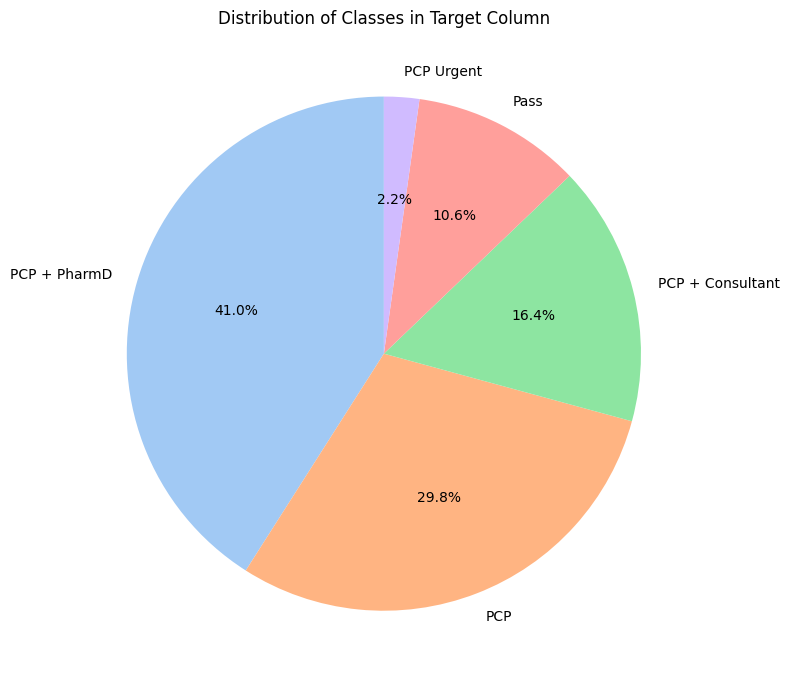

In [66]:
def plot_target_distribution(df):
  # Get the count of each class in the target column
  class_counts = df['target'].value_counts()

  # Plot a pie chart
  plt.figure(figsize=(8, 8))
  plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=90)
  plt.title('Distribution of Classes in Target Column')
  plt.tight_layout()
  plt.show()

plot_target_distribution(df)

### $1^{st}:$ Using SMOTE for OverSampling
The model performance became worse after using SMOTE due to changing the overall class distribution that leads the model to underfit.

In [67]:
# Ensure that each class has the same number of samples as the original majority class
majority_class_count = max(Counter(y_train).values())
sampling_strategy = {cls: majority_class_count for cls in Counter(y_train).keys()}

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=42, sampling_strategy=sampling_strategy)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Check the new class distribution
original_distribution = Counter(y_train)
resampled_distribution = Counter(y_resampled)


In [68]:
# Plot the original and resampled distributions using Plotly
labels = list(original_distribution.keys())
original_counts = list(original_distribution.values())
resampled_counts = [resampled_distribution[label] for label in labels]

def make_dist_plot(original_counts, resampled_counts, labels):
  fig = go.Figure(data=[
    go.Bar(name='Original', x=labels, y=original_counts),
    go.Bar(name='Resampled', x=labels, y=resampled_counts)
  ])

  # Change the bar mode
  fig.update_layout(
    barmode='group',
    title='Class Distribution Before and After SMOTEENN',
    xaxis_title='Class',
    yaxis_title='Count',
    xaxis=dict(type='category')
  )
  fig.show()

make_dist_plot(original_counts, resampled_counts, labels)

In [69]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_resampled, y_resampled)
y_pred = grid_search_dt.predict(X_test)

print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree - Accuracy: 0.4088397790055249 

Decision Tree - Classification Report:
                  precision    recall  f1-score   support

             PCP       0.59      0.41      0.48        54
PCP + Consultant       0.47      0.77      0.58        30
    PCP + PharmD       0.59      0.18      0.27        74
      PCP Urgent       0.75      0.75      0.75         4
            Pass       0.19      0.68      0.30        19

        accuracy                           0.41       181
       macro avg       0.52      0.56      0.48       181
    weighted avg       0.53      0.41      0.40       181



## $2^{nd}:$ Using Data Synthesis and GANs to handle Imbalance


In [70]:
df = df.drop("Case NO", axis=1)

In [71]:
all_numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
numerical_columns = all_numerical_columns[:15]
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns = categorical_columns + all_numerical_columns[15:] + ['Current Smoker']
print(numerical_columns)
print(categorical_columns)
print(len(numerical_columns))
print(len(categorical_columns))

['Age', 'LDL', 'Statin Dose', 'BMI', 'WC', 'HDL', 'Cholesterol', 'CrCl Test', 'TSH', 'Systolic BP', 'Diastolic BP', 'Postprandial', 'Preprandial', 'Number of Meds', 'Heart Rate']
['Statin Used', 'Statin Medications', 'Gender', 'Primary Disease', 'Insulin\n(Yes / No)', 'target', 'Gold Stage', 'Gold Group', 'COPD Pills', 'Asthma Controlled', 'Exacerbation Risk', 'SABA Class', 'SAMA Class', 'ICS Dose', 'Aortic Aneurysm', 'Asthma', 'CKD', 'COPD', 'Carotid Artery Disease', 'Coronary Artery Disease', 'Diabetes', 'Hyperlipidemia', 'Hypertension', 'Ischemic Stroke', 'No Secondary Diseases', 'Obesity', 'Obstructive Sleep Apnea', 'Peripheral Artery Disease', 'Primary Hypothyroidism', 'Current Smoker']
15
30


In [72]:
# !pip install ydata-synthetic

In [73]:
# from ydata_synthetic.synthesizers.regular import RegularSynthesizer
# from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

In [74]:
# # Defining the training parameters
# batch_size = 50
# epochs = 50
# learning_rate = 0.001
# beta_1 = 0.5
# beta_2 = 0.9

# ctgan_args = ModelParameters(batch_size=batch_size,
#                              lr=learning_rate,
#                              betas=(beta_1, beta_2))

# train_args = TrainParameters(epochs=epochs)

# synth = RegularSynthesizer(modelname='ctgan', model_parameters=ctgan_args)
# synth.fit(data=df, num_cols=numerical_columns, cat_cols=categorical_columns, train_arguments=train_args)

In [75]:
# synth_data = synth.sample(500)

In [76]:
synth_data = pd.read_csv("sample_synth_data.csv")
concat_df = pd.concat([df, synth_data], ignore_index=True)
concat_df = concat_df.drop("Case NO", axis=1)
concat_df

,Age,LDL,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,BMI,WC,HDL,...,Coronary Artery Disease,Diabetes,Hyperlipidemia,Hypertension,Ischemic Stroke,No Secondary Diseases,Obesity,Obstructive Sleep Apnea,Peripheral Artery Disease,Primary Hypothyroidism
0,75,179.0,yes,Fluvastatin,42.0,False,male,41.0,38.0,53,...,0,0,1,0,1,0,0,0,0,0
1,63,116.0,yes,Fluvastatin,50.0,False,female,26.0,23.0,42,...,1,0,0,0,1,0,0,0,0,0
2,49,142.0,yes,Fluvastatin,72.0,False,male,34.0,40.0,48,...,0,0,0,0,0,0,0,0,0,0
3,77,74.0,no,No Statin Medication,0.0,True,female,33.0,21.0,45,...,0,0,0,0,0,0,0,0,0,0
4,42,151.0,yes,Atorvastatin,45.0,False,male,37.0,23.0,45,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,59,65.0,no,No Statin Medication,0.0,True,female,24.0,48.0,83,...,0,0,0,1,0,0,0,0,1,0
1699,78,196.0,no,No Statin Medication,0.0,False,male,24.0,28.0,34,...,0,0,0,0,0,0,0,0,0,0
1700,61,114.0,no,No Statin Medication,0.0,False,male,28.0,22.0,92,...,0,0,1,0,0,0,0,0,0,1
1701,37,79.0,yes,Pravastatin,15.0,True,female,22.0,53.0,29,...,0,0,0,0,0,0,0,1,0,0


In [77]:
# Get the list of categorical columns
categorical_cols = concat_df.drop(columns=['target'], axis=1).select_dtypes(include=['object']).columns

# Convert categorical columns into dummy variables
df_encoded = pd.get_dummies(concat_df, columns=categorical_cols)

In [78]:
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [79]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_train, y_train)
y_pred = grid_search_dt.predict(X_test)

print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred), "\n")
print("Decision Tree - Classification Report:")
print(classification_report(y_test, y_pred))

Decision Tree - Accuracy: 0.6979472140762464 

Decision Tree - Classification Report:
                  precision    recall  f1-score   support

             PCP       0.60      0.64      0.62        92
PCP + Consultant       0.78      0.78      0.78        55
    PCP + PharmD       0.80      0.74      0.77       142
      PCP Urgent       0.60      0.43      0.50         7
            Pass       0.55      0.62      0.58        45

        accuracy                           0.70       341
       macro avg       0.67      0.64      0.65       341
    weighted avg       0.71      0.70      0.70       341



## $3{rd}$ Comparison between GANs and SMOTE

- **Accuracy**: The model using GANs performs significantly better than the model using SMOTE, with an accuracy of 0.70 compared to 0.39.

- **Precision**: The precision values in the GANs-based model are generally higher across all classes compared to the SMOTE-based model. This indicates fewer false positives in the GANs-based model.

- **Recall**: The recall values in the GANs-based model are generally higher across all classes compared to the SMOTE-based model. This indicates fewer false negatives in the GANs-based model.

- **F1-Score**: The F1-Scores in the GANs-based model are generally higher across all classes compared to the SMOTE-based model, indicating better balance between precision and recall in the GANs-based model.

- **Macro vs. Weighted Avg**: In both models, the weighted average is lower than the macro average, indicating class imbalances in the dataset.


# Building Basline and Final Models

In [80]:
# Get the list of categorical columns
categorical_cols = df.drop(columns=['target'], axis=1).select_dtypes(include=['object']).columns

# Convert categorical columns into dummy variables
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [81]:
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [82]:
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### BaseLine Models

In [83]:
# Create a baseline dummy classifier
dummy_mst_freg = DummyClassifier(strategy="most_frequent")
dummy_stratified = DummyClassifier(strategy="stratified")

# Train the baseline model
dummy_mst_freg.fit(X_train, y_train)
dummy_stratified.fit(X_train, y_train)

# Make predictions
mst_freg_pred = dummy_mst_freg.predict(X_test)
stratified_pred = dummy_stratified.predict(X_test)

# Calculate accuracy
mst_freg_accuracy = accuracy_score(y_test, mst_freg_pred)
model_stratified_accuracy = accuracy_score(y_test, stratified_pred)

print("Baseline Model Using Most Frequent Strategy Accuracy:", mst_freg_accuracy)
print("Baseline Model Using stratified Strategy Accuracy:", model_stratified_accuracy)

Baseline Model Using Most Frequent Strategy Accuracy: 0.4088397790055249
Baseline Model Using stratified Strategy Accuracy: 0.2430939226519337


### XGBoost Classifier

In [84]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', num_class=len(le.classes_))

# Set up the evaluation data
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model
xgb_clf.fit(X_train, y_train, eval_metric=["mlogloss"], eval_set=eval_set, verbose=False)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Compute the confusion matrix
xg_cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0, target_names=le.classes_))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



Accuracy: 0.7624309392265194
Classification Report:
                  precision    recall  f1-score   support

             PCP       0.74      0.80      0.77        54
PCP + Consultant       0.81      0.70      0.75        30
    PCP + PharmD       0.73      0.85      0.79        74
      PCP Urgent       1.00      1.00      1.00         4
            Pass       1.00      0.37      0.54        19

        accuracy                           0.76       181
       macro avg       0.86      0.74      0.77       181
    weighted avg       0.78      0.76      0.75       181



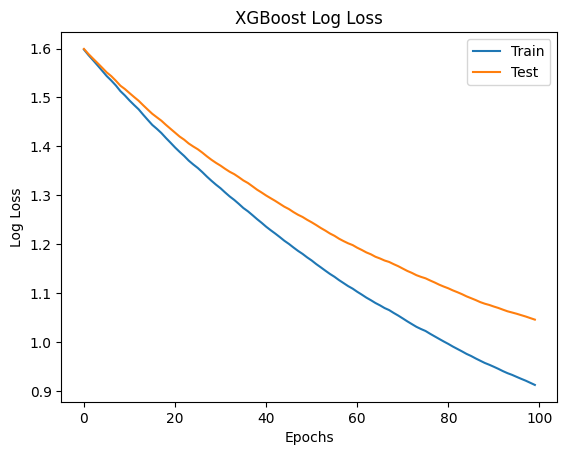

In [85]:
# Plot the training and test log loss over epochs
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot training and validation log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

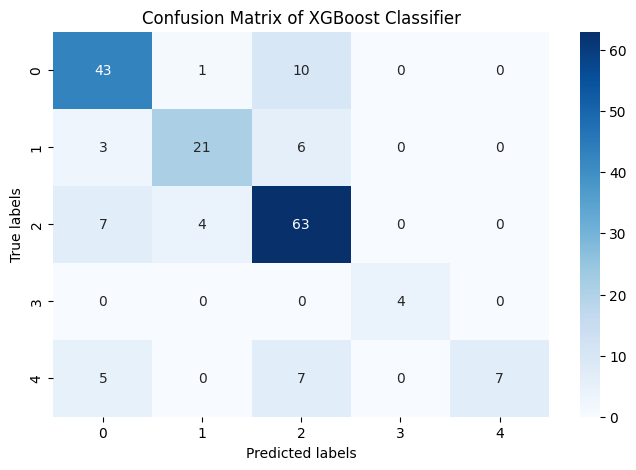

In [86]:
def plot_cm(cm, title= "Confusion Matrix"):
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

plot_cm(xg_cm, "Confusion Matrix of XGBoost Classifier")

### Decision Tree Classifier

In [87]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_train, y_train)
dt_cm = confusion_matrix(y_test, grid_search_dt.predict(X_test))

# Print best parameters and classification report
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Classification Report:")
print(classification_report(y_test, grid_search_dt.predict(X_test)))


Decision Tree - Best Parameters: {'max_depth': 10, 'min_samples_split': 5}
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        54
           1       0.79      0.63      0.70        30
           2       0.82      0.81      0.82        74
           3       1.00      0.50      0.67         4
           4       0.58      0.79      0.67        19

    accuracy                           0.75       181
   macro avg       0.78      0.69      0.72       181
weighted avg       0.76      0.75      0.75       181



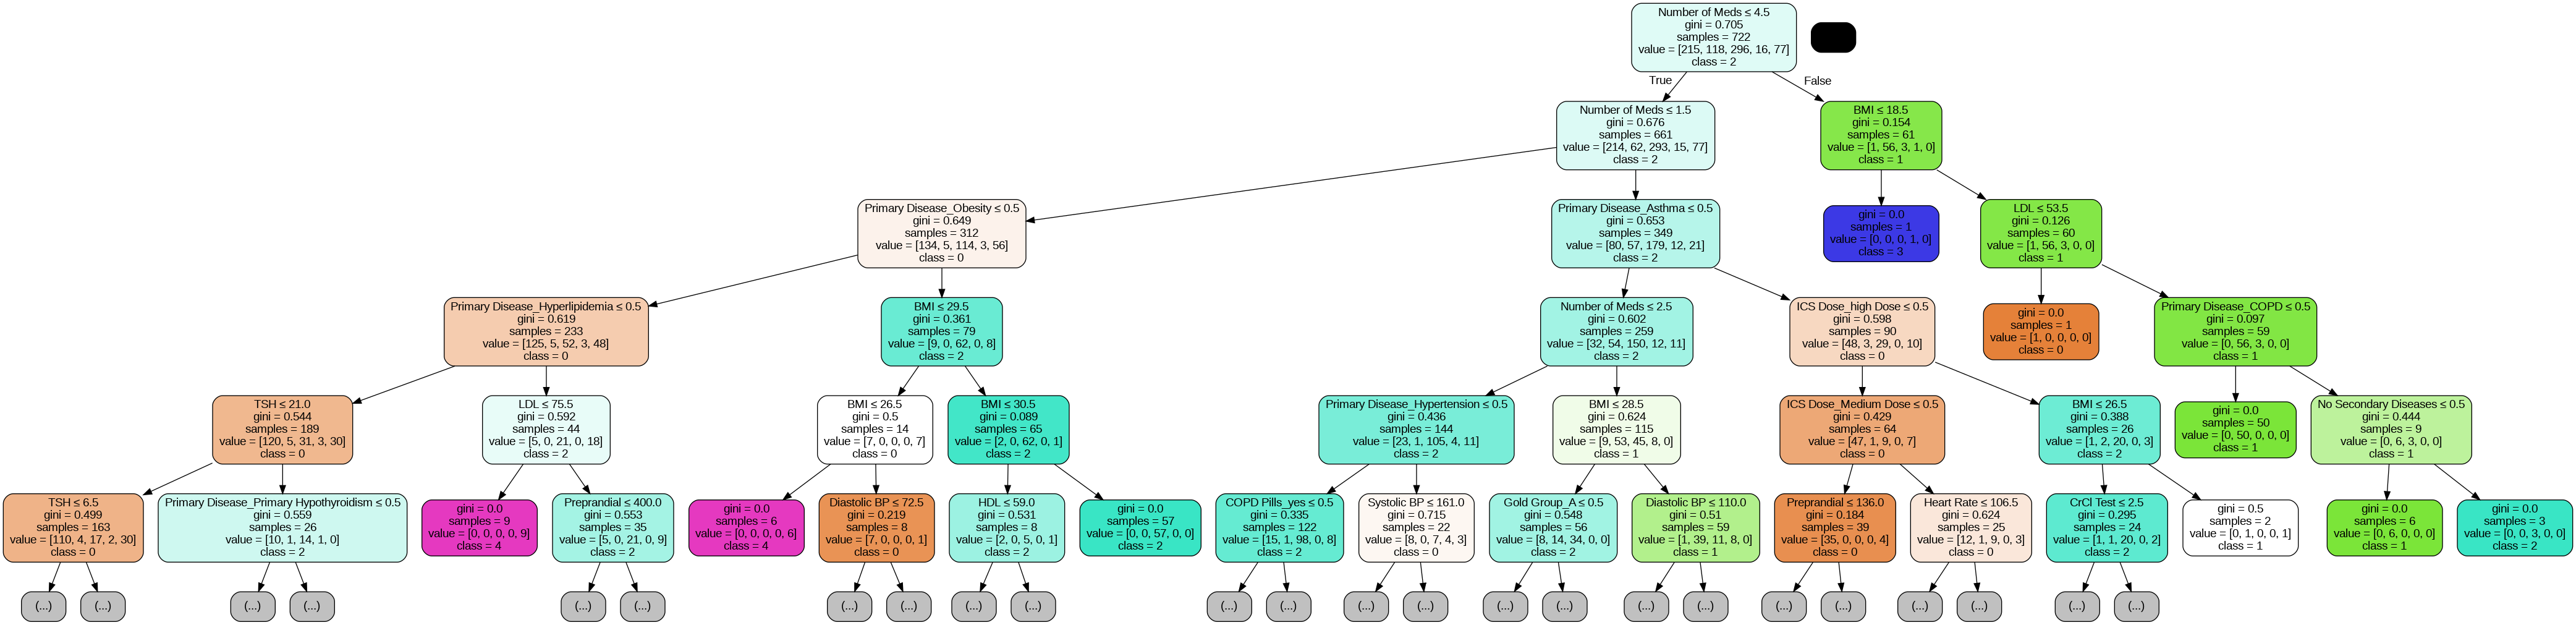

In [88]:
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

# Get the best decision tree model
best_dt = grid_search_dt.best_estimator_

# Export the decision tree to DOT format
dot_data = export_graphviz(
    best_dt,
    out_file=None,
    feature_names=X_train.columns,
    class_names=np.unique(y_train).astype(str),
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=5  # Limit the depth of the tree
)

# Create a graph from the DOT data
graph = pydotplus.graph_from_dot_data(dot_data)

# Create a PNG image
png_image = graph.create_png()

# Display the tree
Image(png_image)


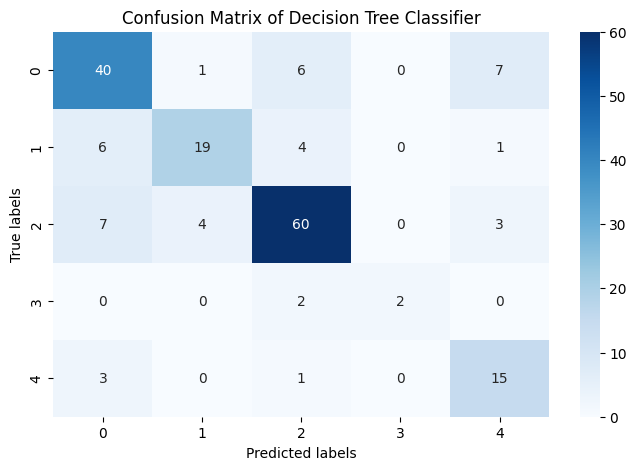

In [89]:
plot_cm(dt_cm, "Confusion Matrix of Decision Tree Classifier")

In [90]:
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_score = best_dt.predict_proba(X_test)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

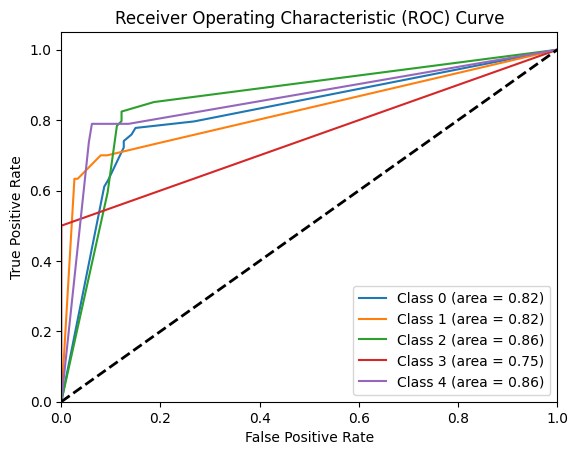

In [91]:
# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

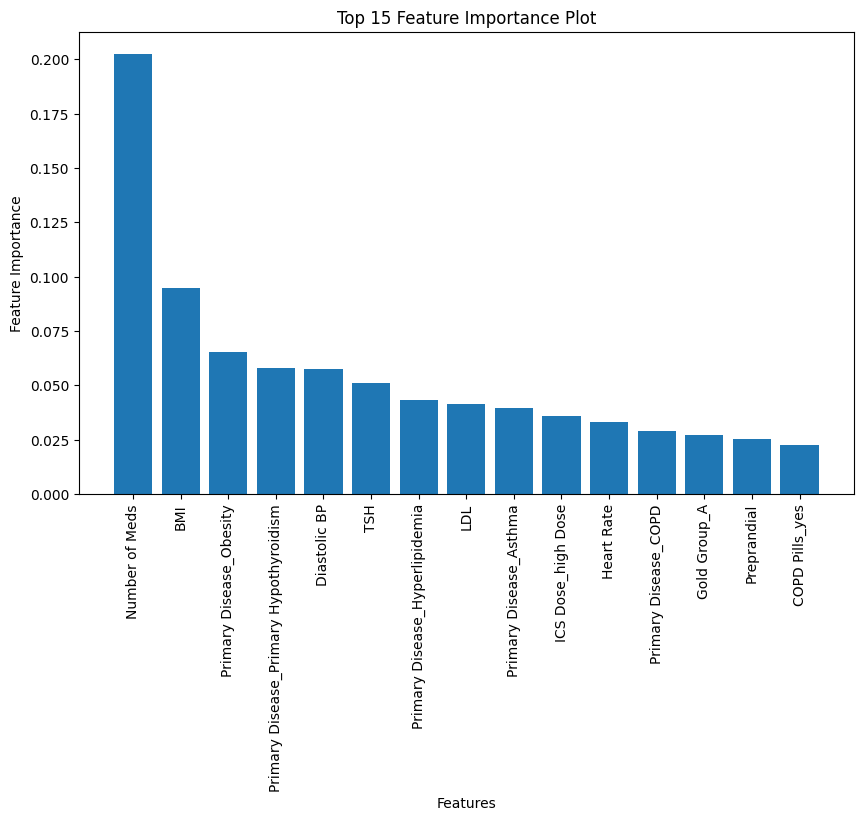

In [92]:
# Get feature importances
importances = best_dt.feature_importances_
features = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select top 15 features
top_n = 15
sorted_features = [features[i] for i in indices[:top_n]]
sorted_importances = importances[indices][:top_n]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(top_n), sorted_importances)
plt.xticks(range(top_n), sorted_features, rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Top 15 Feature Importance Plot')
plt.show()

### Random Forest Classifier

In [93]:
# Define Random Forest classifier
rf = RandomForestClassifier()

# Define parameter grid for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_rf.fit(X_train, y_train)
y_pred = grid_search_rf.predict(X_test)


# Print best parameters and classification report
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred , zero_division=0))


Random Forest - Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.57      0.56        54
           1       0.90      0.60      0.72        30
           2       0.63      0.86      0.73        74
           3       1.00      0.75      0.86         4
           4       0.00      0.00      0.00        19

    accuracy                           0.64       181
   macro avg       0.62      0.56      0.57       181
weighted avg       0.59      0.64      0.60       181



## Experiment II

### Encoding data with different Approch

In [94]:
# Define the column mapping
column_mapping = {
    'Statin Used': {"yes": 1, "no": 0},
    'Current Smoker': {True: 1, False: 0},
    'Gender': {"female": 1, "male": 0},
    'Insulin\n(Yes / No)': {"Yes": 1, "No": 0},
    'SABA Class': {"yes": 1, "no": 0},
    'SAMA Class': {"yes": 1, "no": 0},
    'Exacerbation Risk': {"high": 1, "low": 0},
    'COPD Pills': {"yes": 1, "no": 0},
    'Asthma Controlled': {"well controlled": 1, "poorly controlled": 0, "partially controlled": 2},
    'ICS Dose': {"high Dose": 1, "low Dose": 0, "Medium Dose": 2}
}

In [95]:
def map_categorical_columns(df, column_mapping):
    """
    Maps values in specified categorical columns of a DataFrame according to the provided mapping.

    Parameters:
    df (pd.DataFrame): The DataFrame containing categorical columns to map.
    column_mapping (dict): Dictionary specifying the mapping for each column.

    Returns:
    pd.DataFrame: The DataFrame with mapped categorical columns.
    """
    df_mapped = df.copy()
    for column, mapping in column_mapping.items():
        df_mapped[column] = df_mapped[column].map(mapping)
    return df_mapped

def encode_dataframe(df, column_mapping):
    """
    Encodes a DataFrame by:
    - Mapping binary categorical features to 0s and 1s.
    - Using pd.get_dummies for other categorical features.

    Parameters:
    df (pd.DataFrame): The DataFrame to encode.
    column_mapping (dict): Dictionary specifying the mapping for each categorical column.

    Returns:
    pd.DataFrame: The encoded DataFrame.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_encoded = df.copy()

    # Apply the function to map categorical columns
    df_mapped = map_categorical_columns(df_encoded, column_mapping)

    # Identify non-binary categorical features (excluding the binary ones)
    non_binary_features = [col for col in df_mapped.columns if df_mapped[col].dtype == 'object' and df_mapped[col].nunique() > 2 and col not in ['Asthma Controlled']]

    # Apply pd.get_dummies to non-binary categorical features
    if non_binary_features:
        df_mapped = pd.get_dummies(df_mapped, columns=non_binary_features)

    return df_mapped


# Assuming df_cleaned_data is your DataFrame
df_encoded_data = encode_dataframe(df.drop(columns=['target', "Statin Medications", "Gold Stage", "Gold Group"], axis=1),column_mapping )
df_encoded_data["target"] = df["target"]
df_encoded_data


,Age,LDL,Statin Used,Statin Dose,Current Smoker,Gender,BMI,WC,HDL,Cholesterol,...,Peripheral Artery Disease,Primary Hypothyroidism,Primary Disease_Asthma,Primary Disease_COPD,Primary Disease_Diabetes,Primary Disease_Hyperlipidemia,Primary Disease_Hypertension,Primary Disease_Obesity,Primary Disease_Primary Hypothyroidism,target
0,75,179.0,1,42.0,0,0,41.0,38.0,53,213.0,...,0,0,False,False,False,False,True,False,False,PCP
1,63,116.0,1,50.0,0,1,26.0,23.0,42,93.0,...,0,0,False,False,False,False,True,False,False,Pass
2,49,142.0,1,72.0,0,0,34.0,40.0,48,119.0,...,0,0,False,False,False,False,True,False,False,PCP + PharmD
3,77,74.0,0,0.0,1,1,33.0,21.0,45,145.0,...,0,0,False,False,False,False,True,False,False,PCP
4,42,151.0,1,45.0,0,0,37.0,23.0,45,209.0,...,0,0,False,False,False,False,True,False,False,PCP + Consultant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,39,69.0,1,13.0,1,0,26.0,36.0,43,155.0,...,0,0,False,False,False,False,False,False,True,PCP
899,56,128.0,0,0.0,0,0,26.0,40.0,65,135.0,...,0,0,False,False,False,False,False,False,True,PCP + PharmD
900,53,87.0,0,0.0,0,1,25.0,28.0,71,178.0,...,0,0,False,False,False,False,False,False,True,PCP
901,81,104.0,1,33.0,0,0,23.0,54.0,83,183.0,...,0,0,False,False,False,False,False,False,True,PCP + PharmD


In [96]:
# Splitting data into features (X) and target (y)
X = df_encoded_data.drop(columns=['target'], axis=1)
y = df_encoded_data['target']

# Perform train-test split with 90% training and 10% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [97]:
# Calculate the number of NaN values in the feature matrix X
num_nan_values = X_train.isna().sum().sum() + X_test.isna().sum().sum()

print("Number of NaN values in the feature matrix X:", num_nan_values)

Number of NaN values in the feature matrix X: 25


In [98]:
# Drop rows with NaN values from the feature matrix X_train and y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Drop rows with NaN values from the feature matrix X_test and y_test
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Print the shape of X_train and X_test after dropping NaN values
print("Shape of X_train after dropping NaN values:", X_train.shape)
print("Shape of X_test after dropping NaN values:", X_test.shape)

Shape of X_train after dropping NaN values: (701, 47)
Shape of X_test after dropping NaN values: (177, 47)


In [99]:
# Apply one-hot encoding to the target variable
encoder = OneHotEncoder(sparse_output=False)  # the output will be a dense array

# Fit and transform the training target data
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))

# Transform the test target data
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Displaying the results
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train_encoded:", y_train.shape)
print("y_test_encoded:", y_test.shape)

X_train: (701, 47)
X_test: (177, 47)
y_train_encoded: (701,)
y_test_encoded: (177,)


In [100]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [101]:
# Define XGBoost classifier
xgb = XGBClassifier()

# Define parameter grid for grid search
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Grid search with cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_xgb.fit(X_train_scaled, y_train_encoded)

# Print best parameters and classification report
print("XGBoost - Best Parameters:", grid_search_xgb.best_params_)
print("XGBoost - Classification Report:")
print(classification_report(y_test_encoded, grid_search_xgb.predict(X_test_scaled), zero_division=0))


XGBoost - Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        54
           1       0.87      0.69      0.77        29
           2       0.64      0.66      0.65        70
           3       1.00      1.00      1.00         4
           4       0.40      0.10      0.16        20

   micro avg       0.68      0.56      0.62       177
   macro avg       0.71      0.59      0.63       177
weighted avg       0.66      0.56      0.60       177
 samples avg       0.55      0.56      0.55       177



In [102]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_train_scaled, y_train_encoded)
y_pred = grid_search_dt.predict(X_test_scaled)

# Print best parameters and classification report
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Classification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=0))


Decision Tree - Best Parameters: {'max_depth': None, 'min_samples_split': 2}
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        54
           1       0.64      0.55      0.59        29
           2       0.70      0.81      0.75        70
           3       0.75      0.75      0.75         4
           4       0.69      0.45      0.55        20

   micro avg       0.68      0.68      0.68       177
   macro avg       0.69      0.64      0.66       177
weighted avg       0.68      0.68      0.67       177
 samples avg       0.68      0.68      0.68       177



In [103]:
# Define Random Forest classifier
rf = RandomForestClassifier()

# Define parameter grid for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_rf.fit(X_train_scaled, y_train_encoded)
y_pred = grid_search_rf.predict(X_test_scaled)

# Print best parameters and classification report
print("Random Forest - Best Parameters:", grid_search_rf.best_params_)
print("Random Forest - Classification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=0))


Random Forest - Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.19      0.29        54
           1       0.94      0.55      0.70        29
           2       0.69      0.51      0.59        70
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        20

   micro avg       0.75      0.35      0.48       177
   macro avg       0.47      0.25      0.32       177
weighted avg       0.65      0.35      0.44       177
 samples avg       0.35      0.35      0.35       177



In [104]:
from sklearn.multioutput import MultiOutputClassifier

# Create a Voting Classifier combining the best models
best_estimators = [
    ('xgb', grid_search_xgb.best_estimator_),
    ('dt', grid_search_dt.best_estimator_),
    ('rf', grid_search_rf.best_estimator_)
]

voting_classifier = VotingClassifier(estimators=best_estimators)

# Create a MultiOutputClassifier with the Voting Classifier
multi_voting_classifier = MultiOutputClassifier(voting_classifier)

# Fit the MultiOutputClassifier
multi_voting_classifier.fit(X_train_scaled, y_train_encoded)
y_pred = multi_voting_classifier.predict(X_test_scaled)

# Print classification report for MultiOutputClassifier
print("MultiOutput Voting Classifier - Classification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=0))



MultiOutput Voting Classifier - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.48      0.59        54
           1       0.95      0.69      0.80        29
           2       0.72      0.66      0.69        70
           3       1.00      1.00      1.00         4
           4       0.00      0.00      0.00        20

   micro avg       0.76      0.54      0.63       177
   macro avg       0.69      0.57      0.62       177
weighted avg       0.70      0.54      0.61       177
 samples avg       0.52      0.54      0.53       177



In [105]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for XGBoost model
xgb_accuracy = accuracy_score(y_test_encoded, grid_search_xgb.predict(X_test_scaled))
print("XGBoost - Accuracy:", xgb_accuracy)

# Calculate accuracy for Decision Tree model
dt_accuracy = accuracy_score(y_test_encoded, grid_search_dt.predict(X_test_scaled))
print("Decision Tree - Accuracy:", dt_accuracy)

# Calculate accuracy for Random Forest model
rf_accuracy = accuracy_score(y_test_encoded, grid_search_rf.predict(X_test_scaled))
print("Random Forest - Accuracy:", rf_accuracy)

# Calculate accuracy for Voting Classifier model
voting_accuracy = accuracy_score(y_test_encoded, multi_voting_classifier.predict(X_test_scaled))
print("Voting Classifier - Accuracy:", voting_accuracy)


XGBoost - Accuracy: 0.5310734463276836
Decision Tree - Accuracy: 0.6779661016949152
Random Forest - Accuracy: 0.3502824858757062
Voting Classifier - Accuracy: 0.5028248587570622


## Removing Secondry Disease Column for high Cardinality

In [106]:
df_non_miss = df.iloc[:, :31]
df_non_miss

,Age,LDL,Statin Used,Statin Medications,Statin Dose,Current Smoker,Gender,BMI,WC,HDL,...,Heart Rate,Gold Stage,Gold Group,COPD Pills,Asthma Controlled,Exacerbation Risk,SABA Class,SAMA Class,ICS Dose,Aortic Aneurysm
0,75,179.0,yes,Fluvastatin,42.0,False,male,41.0,38.0,53,...,111,4,Unknown,yes,poorly controlled,high,yes,no,high Dose,0
1,63,116.0,yes,Fluvastatin,50.0,False,female,26.0,23.0,42,...,76,1,A,no,well controlled,low,yes,yes,Medium Dose,0
2,49,142.0,yes,Fluvastatin,72.0,False,male,34.0,40.0,48,...,54,1,B,no,well controlled,high,no,yes,Medium Dose,0
3,77,74.0,no,No Statin Medication,0.0,True,female,33.0,21.0,45,...,95,3,Unknown,yes,partially controlled,high,no,yes,low Dose,0
4,42,151.0,yes,Atorvastatin,45.0,False,male,37.0,23.0,45,...,39,1,D,yes,partially controlled,high,yes,yes,low Dose,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,39,69.0,yes,Atorvastatin,13.0,True,male,26.0,36.0,43,...,79,unknown,B,yes,well controlled,high,no,yes,Medium Dose,0
899,56,128.0,no,No Statin Medication,0.0,False,male,26.0,40.0,65,...,110,2,D,no,poorly controlled,low,yes,yes,Medium Dose,0
900,53,87.0,no,No Statin Medication,0.0,False,female,25.0,28.0,71,...,61,unknown,D,yes,poorly controlled,low,yes,no,high Dose,0
901,81,104.0,yes,Pravastatin,33.0,False,male,23.0,54.0,83,...,77,4,A,yes,partially controlled,high,yes,yes,high Dose,0


In [107]:
# Get the list of categorical columns
categorical_cols = df_non_miss.drop(columns=['target'], axis=1).select_dtypes(include=['object']).columns

# Convert categorical columns into dummy variables
df_encoded = pd.get_dummies(df_non_miss, columns=categorical_cols)

In [108]:
df_encoded

,Age,LDL,Statin Dose,Current Smoker,BMI,WC,HDL,Cholesterol,CrCl Test,TSH,...,Exacerbation Risk_high,Exacerbation Risk_low,SABA Class_no,SABA Class_yes,SAMA Class_no,SAMA Class_yes,ICS Dose_Medium Dose,ICS Dose_NO ICS,ICS Dose_high Dose,ICS Dose_low Dose
0,75,179.0,42.0,False,41.0,38.0,53,213.0,29.0,10.0,...,True,False,False,True,True,False,False,False,True,False
1,63,116.0,50.0,False,26.0,23.0,42,93.0,13.0,13.0,...,False,True,False,True,False,True,True,False,False,False
2,49,142.0,72.0,False,34.0,40.0,48,119.0,12.0,3.0,...,True,False,True,False,False,True,True,False,False,False
3,77,74.0,0.0,True,33.0,21.0,45,145.0,58.0,10.0,...,True,False,True,False,False,True,False,False,False,True
4,42,151.0,45.0,False,37.0,23.0,45,209.0,86.0,2.0,...,True,False,False,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,39,69.0,13.0,True,26.0,36.0,43,155.0,48.0,16.0,...,True,False,True,False,False,True,True,False,False,False
899,56,128.0,0.0,False,26.0,40.0,65,135.0,60.0,11.0,...,False,True,False,True,False,True,True,False,False,False
900,53,87.0,0.0,False,25.0,28.0,71,178.0,52.0,8.0,...,False,True,False,True,True,False,False,False,True,False
901,81,104.0,33.0,False,23.0,54.0,83,183.0,90.0,5.0,...,True,False,False,True,False,True,False,False,True,False


In [109]:
X = df_encoded.drop(columns=['target'])
y = df_encoded['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [110]:
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### XGBoost Classifier

In [111]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', num_class=len(le.classes_))

# Set up the evaluation data
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model
xgb_clf.fit(X_train, y_train, eval_metric=["mlogloss"], eval_set=eval_set, verbose=False)

# Make predictions on the test set
y_pred = xgb_clf.predict(X_test)

# Compute the confusion matrix
xg_cm = confusion_matrix(y_test, y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0, target_names=le.classes_))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



Accuracy: 0.7845303867403315
Classification Report:
                  precision    recall  f1-score   support

             PCP       0.74      0.83      0.78        54
PCP + Consultant       0.83      0.80      0.81        30
    PCP + PharmD       0.78      0.84      0.81        74
      PCP Urgent       1.00      1.00      1.00         4
            Pass       1.00      0.37      0.54        19

        accuracy                           0.78       181
       macro avg       0.87      0.77      0.79       181
    weighted avg       0.80      0.78      0.78       181



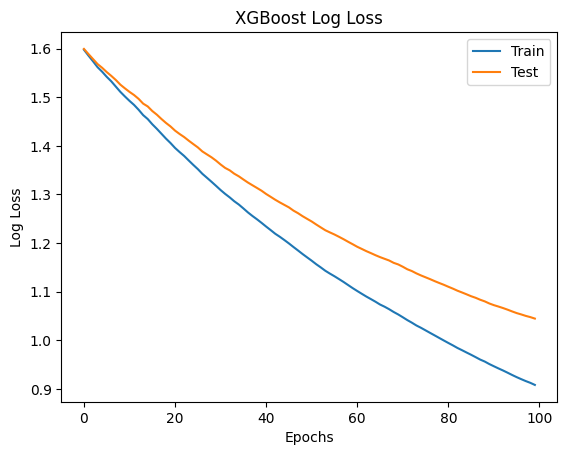

In [112]:
# Plot the training and test log loss over epochs
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot training and validation log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

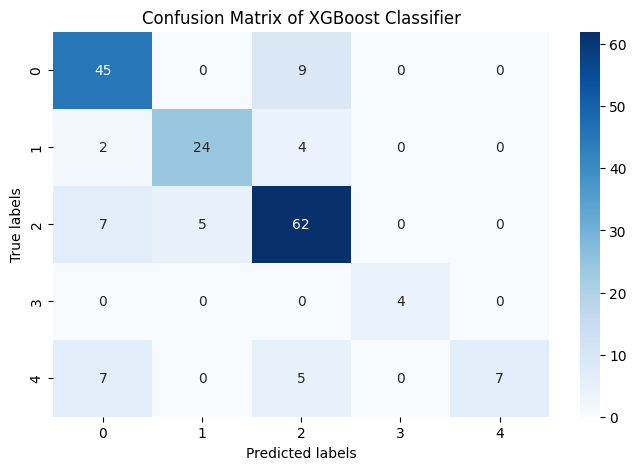

In [113]:
def plot_cm(cm, title= "Confusion Matrix"):
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

plot_cm(xg_cm, "Confusion Matrix of XGBoost Classifier")

### Decision Tree Classifier

In [114]:
# Define Decision Tree classifier
dt = DecisionTreeClassifier()

# Define parameter grid for grid search
param_grid_dt = {
    'max_depth': [3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid search with cross-validation
grid_search_dt = GridSearchCV(dt, param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_dt.fit(X_train, y_train)
dt_cm = confusion_matrix(y_test, grid_search_dt.predict(X_test))

# Print best parameters and classification report
print("Decision Tree - Best Parameters:", grid_search_dt.best_params_)
print("Decision Tree - Classification Report:")
print(classification_report(y_test, grid_search_dt.predict(X_test)))


Decision Tree - Best Parameters: {'max_depth': 10, 'min_samples_split': 2}
Decision Tree - Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73        54
           1       0.81      0.70      0.75        30
           2       0.86      0.84      0.85        74
           3       1.00      0.50      0.67         4
           4       0.62      0.84      0.71        19

    accuracy                           0.78       181
   macro avg       0.80      0.72      0.74       181
weighted avg       0.79      0.78      0.78       181

